In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"birth": 0.5, "death": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

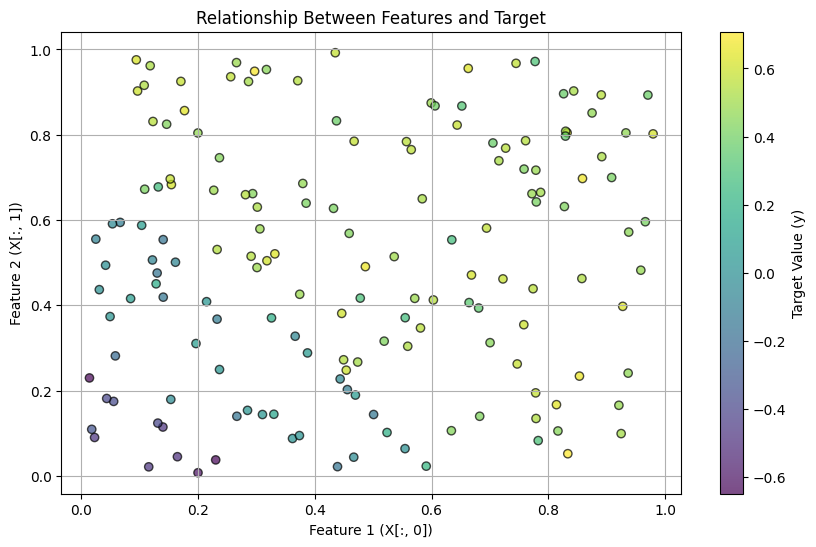

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=50, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 50, theta_df = np.inf, 
                         tree_num_prior_type="poisson", special_move_interval=1)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [00:39<00:00, 101.97it/s]


In [5]:
bart.trace[-1].n_trees

48

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00548958]), 'ntree_theta': 50}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

49.692

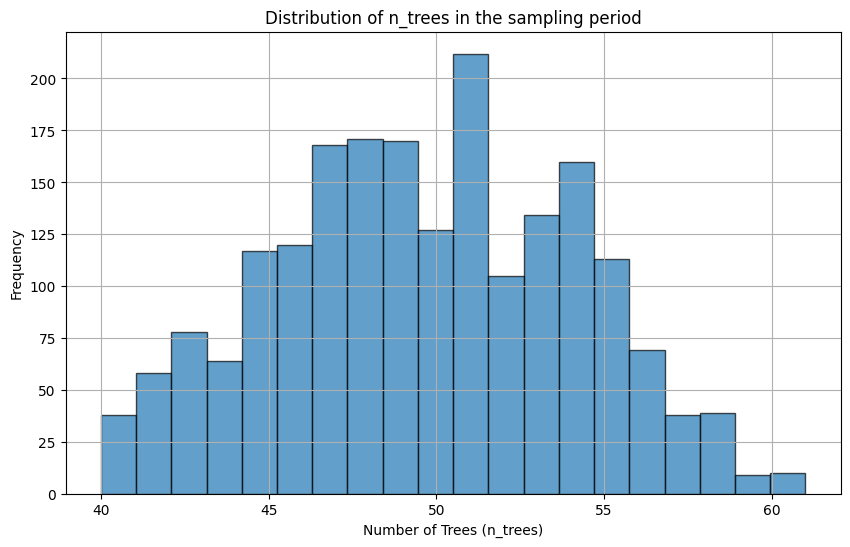

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

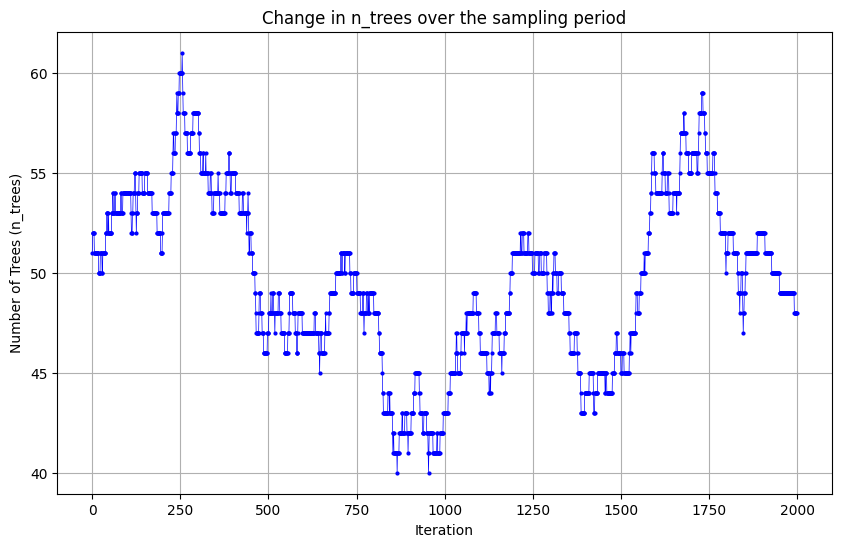

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-13 00:42:52,033:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-13 00:42:52,035:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.29 A_prune=0.45 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.20 A_prune=0.17
Iteration 300/300 P_grow=0.69 P_prune=0.31 A_grow=0.36 A_prune=0.27


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.02143950649478311,
 'rf': 0.02011792490912275,
 'lr': 0.048045521328019404,
 'btz': 0.02235669406530368}

In [12]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [13]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [14]:
bart.sampler.trace[-1].evaluate()

array([ 0.33747294,  0.30077478,  0.14133117,  0.26906683,  0.34555692,
        0.31417381, -0.39443409,  0.42036544, -0.09332013, -0.01007327,
        0.27629582,  0.28792224,  0.39924325,  0.30077478,  0.29382841,
        0.38057798,  0.05336715,  0.33245771,  0.32796907,  0.33080301,
        0.06554707, -0.31164762,  0.34953881,  0.30434401,  0.30697653,
        0.32806918,  0.49751297,  0.31281211,  0.39257758,  0.41479623,
       -0.40248323,  0.36076123,  0.02597812,  0.04213631,  0.40435495,
        0.30639817,  0.28730978,  0.40435495, -0.39136562,  0.14496466,
        0.31923363,  0.38057798,  0.32665652, -0.04654947, -0.01271112,
        0.32870221, -0.43501435,  0.3064532 ,  0.36398517,  0.087143  ,
        0.30077478,  0.41030899,  0.34716686,  0.33587474,  0.27692802,
       -0.03616611,  0.3830708 ,  0.2961898 ,  0.27784048,  0.32796907,
        0.40435495,  0.33347164,  0.34204075,  0.36238459,  0.07949361,
        0.32451142,  0.24914033, -0.01601891,  0.22453889,  0.05

In [15]:
bart.sampler.trace[-1].evaluate(X_train)

array([ 0.33747294,  0.30077478,  0.14133117,  0.26906683,  0.34555692,
        0.31417381, -0.39443409,  0.42036544, -0.09332013, -0.01007327,
        0.27629582,  0.28792224,  0.39924325,  0.30077478,  0.29382841,
        0.38057798,  0.05336715,  0.33245771,  0.32796907,  0.33080301,
        0.06554707, -0.31164762,  0.34953881,  0.30434401,  0.30697653,
        0.32806918,  0.49751297,  0.31281211,  0.39257758,  0.41479623,
       -0.40248323,  0.36076123,  0.02597812,  0.04213631,  0.40435495,
        0.30639817,  0.28730978,  0.40435495, -0.39136562,  0.14496466,
        0.31923363,  0.38057798,  0.32665652, -0.04654947, -0.01271112,
        0.32870221, -0.43501435,  0.3064532 ,  0.36398517,  0.087143  ,
        0.30077478,  0.41030899,  0.34716686,  0.33587474,  0.27692802,
       -0.03616611,  0.3830708 ,  0.2961898 ,  0.27784048,  0.32796907,
        0.40435495,  0.33347164,  0.34204075,  0.36238459,  0.07949361,
        0.32451142,  0.24914033, -0.01601891,  0.22453889,  0.05

In [16]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 1002; mh median: 0.03145811302088474


In [17]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 48; mh median: 19.605759715386927


In [18]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 476; mh median: 0.5649670339669572


In [19]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 844; mh median: 0.1356414102541494


In [20]:
bart.trace[-1].trees

[Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.04302845        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan -0.05445771  0.01674774         nan         nan         nan
          nan         nan], n_vals=[120   5 115  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.48730233        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan  0.02437379 -0.03029166         nan         nan         nan
          nan         nan], n_vals=[120  70  50  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1  0 -2 -2 -1  0 -2 -2 -2 -2 -2 -2 -1 -1 -2], thresholds=[0.03113082        nan 0.16394061        nan        nan        nan
  0.93705634        nan        nan        nan        nan        nan
         nan        nan        nan        nan], leaf_vals=[        nan -0.00503617         nan         nan         nan -0.00605027
          nan         nan         nan         nan         nan        